In [1]:
using CSV
using DataFrames
using JuMP
using Plots
using Random
using Statistics
using LinearAlgebra
using Distributions
using BipartiteMatching
using Gurobi
using LinearAlgebra
using SymPy
using NLsolve
using LaTeXStrings


# Proof of Theorem 3

### Goal
The notebook aims to verify if the lower bound of $\mu(1,0) - \mu(1/2,1/2) > 0$ within each set [alphaf, alphaf + delta) $\times$ [alpha,alpha + delta).

### Arguments
- `x_lb` `x1_lb` `x2_lb` `x_ub` `x1_ub` `x2_ub`: The respective lower and upper bounds of $x, x_1$ and $x_2$.
- `alphaf` or `alphaf_val`: Value of $\alpha^f$.
- `alpha` or `alpha_val`: Value of $\alpha$.
- `delta` or `delta_val`: Small positive increment.

### Functions
- `equation_x!(F, x, alphaf_val, alpha_val)` and `equation_x1!(F, x, alphaf_val, alpha_val)` return the numerical solutions of $x, x_1$ and $x_2$. `lb_comparison` uses these values to build a lower bound of $\mu(1,0) - \mu(1/2,1/2)$ for a set [alphaf, alphaf + delta) $\times$ [alpha,alpha + delta).
- `comp_f_func(alphaf_val, alpha_val, delta_val)` returns whether the lower bound > 0.
- `calculate_lb_comparison_matrix(delta_val)` examines all alphaf and alpha within the claimed region.

### Outputs
- `calculate_lb_comparison_matrix(delta_val)` returns a boolean matrix, which we plot in heatmap so that (1) the inequality holds in the red region (2) fails in the blue region, and (3) in the grey region the parameters fall outside the tree-like regime.

In [2]:
# Define an expression to compute the lower bound of mu(1,0) - mu(1/2,1/2) in each set.
@vars delta alphaf alpha x_lb x1_lb x2_lb x_ub x1_ub x2_ub
lb_comparison = -x_ub-exp(-(alphaf+alpha)*x_lb)*(1+(alphaf+alpha+2*delta)*x_ub)+0.5*x1_lb+0.5*x2_lb + 0.5*exp(
    -(alphaf+delta)*x1_ub-0.5*(alphaf+alpha+2*delta)*x2_ub)*(1+(alphaf)*x1_lb+0.5*(alphaf+alpha)*x2_lb)+0.5*exp(
    -0.5*(alphaf+alpha+2*delta)*x1_ub-(alpha+delta)*x2_ub)*(1+0.5*(alphaf+alpha)*x1_lb+(alpha)*x2_lb)

# Define a Julia function to solve x.
function equation_x!(F, x, alphaf_val, alpha_val)
    F[1] = exp(-(alphaf_val + alpha_val)*x[1]) - x[1]
end

# Define a Julia function to solve x1.
function equation_x1!(F, x, alphaf_val, alpha_val)
    F[1] = exp(-0.5*(alphaf_val + alpha_val)*x[1] + 2*alpha_val*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)) + 2*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)
end

# Define a Julia function to verify if the lower bound > 0.
tolerance = 1e-8
function comp_f_func(alphaf_val, alpha_val, delta_val)
    x_sol = nlsolve((F, x) -> equation_x!(F, x, alphaf_val, alpha_val), [0.2], autodiff=:forward, ftol=tolerance).zero[1]
    x_sol_ub, x_sol_lb = x_sol+tolerance, x_sol-tolerance
    x1_sol = nlsolve((F, x) -> equation_x1!(F, x, alphaf_val, alpha_val), [0.2], autodiff=:forward, ftol=tolerance).zero[1]
    x1_sol_ub, x1_sol_lb = x1_sol+tolerance, x1_sol-tolerance
    x2_sol_ub, x2_sol_lb = -2*(log(x1_sol_lb) + alphaf_val*x1_sol_lb)/(alphaf_val + alpha_val), -2*(log(x1_sol_ub) + alphaf_val*x1_sol_ub)/(alphaf_val + alpha_val)
    lb_comparison_val = subs(lb_comparison, (alphaf, alphaf_val), (alpha, alpha_val), 
        (x_lb, x_sol_lb*(1-delta)), (x_ub, x_sol_ub), 
        (x1_lb, x1_sol_lb*(1-2*delta)), (x2_lb, x2_sol_lb*(1-2*delta)), 
        (x1_ub, x1_sol_ub), (x2_ub, x2_sol_ub),(delta,delta_val))
    return lb_comparison_val > 0
end

# This function iterates over alphaf and alpha, recording 1 if the inequality is satisfied, 0 if it fails, and -1 if the parameters fall outside the tree-like regime.
function calculate_lb_comparison_matrix(delta_val)
    
    alphaf_range = delta_val:delta_val:exp(1)
    alpha_range = 0.0:delta_val:exp(1)/2
    results_matrix = Matrix{Int}(undef, length(alphaf_range), length(alpha_range))

    for (i, alphaf_val) in enumerate(alphaf_range)
        print(alphaf_val, '\n')
        for (j, alpha_val) in enumerate(alpha_range)
            if alpha_val <= min(alphaf_val, exp(1) - alphaf_val)
                results_matrix[i, j] = comp_f_func(alphaf_val, alpha_val, delta_val)
            else
                results_matrix[i, j] = -1 
            end
        end
    end
    
    return results_matrix

end


calculate_lb_comparison_matrix (generic function with 1 method)

In [ ]:
# delta = 0.01: runtime ~ 15 min
delta_val = 0.01
results_matrix = calculate_lb_comparison_matrix(delta_val)
CSV.write("compare01.csv", DataFrame(results_matrix, :auto), writeheader=false)

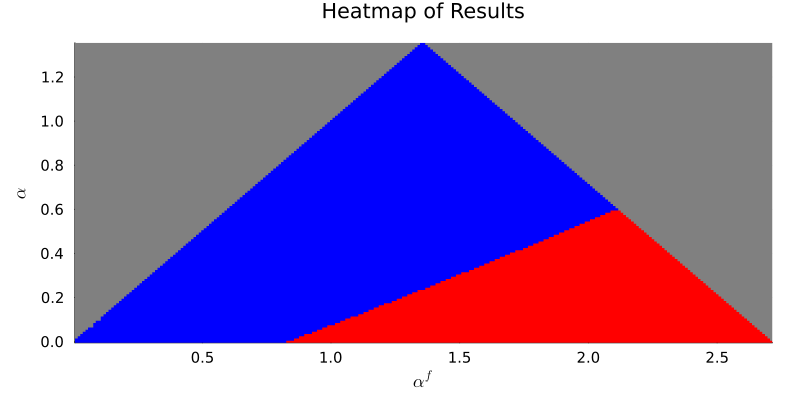

In [3]:
# Specify delta and load results
delta_val = 0.01

loaded_dataframe = CSV.File("compare01.csv", header=false) |> DataFrame
results_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)
plot!(size=(800, 400), margin=5Plots.mm)

In [ ]:
# delta_val = 0.005: runtime ~ 60 min
delta_val = 0.005
results_matrix = calculate_lb_comparison_matrix(delta_val)
CSV.write("compare005.csv", DataFrame(results_matrix, :auto), writeheader=false)

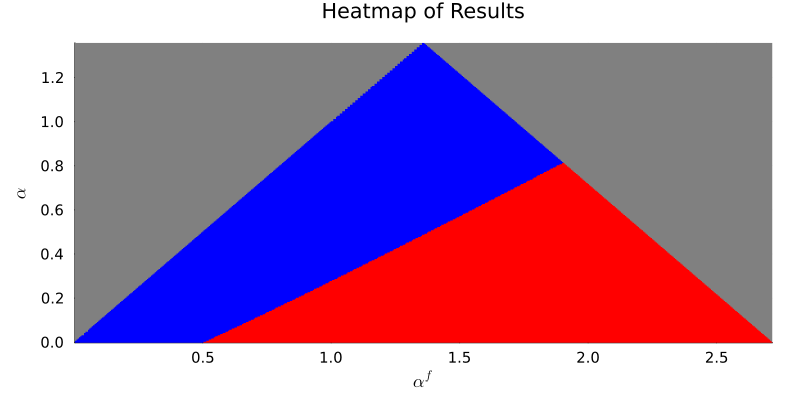

In [4]:
# Specify delta and load results
delta_val = 0.005

loaded_dataframe = CSV.File("compare005.csv", header=false) |> DataFrame
results_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)
plot!(size=(800, 400), margin=5Plots.mm)

In [ ]:
# delta_val = 0.0025: runtime ~ 4 hours
delta_val = 0.0025
results_matrix = calculate_lb_comparison_matrix(delta_val)
CSV.write("compare0025.csv", DataFrame(results_matrix, :auto), writeheader=false)

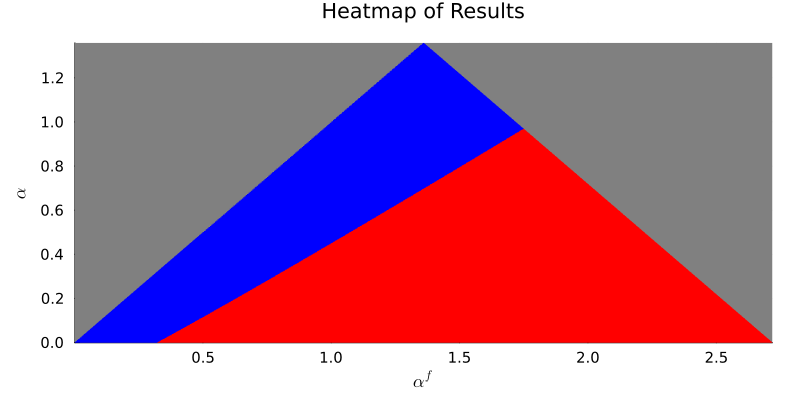

In [5]:
# Specify delta and load results
delta_val = 0.0025

loaded_dataframe = CSV.File("compare0025.csv", header=false) |> DataFrame
results_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)
plot!(size=(800, 400), margin=5Plots.mm)

In [ ]:
# delta_val = 0.001: runtime ~ 20 hours
delta_val = 0.001
results_matrix = calculate_lb_comparison_matrix(delta_val)
CSV.write("compare001.csv", DataFrame(results_matrix, :auto), writeheader=false)

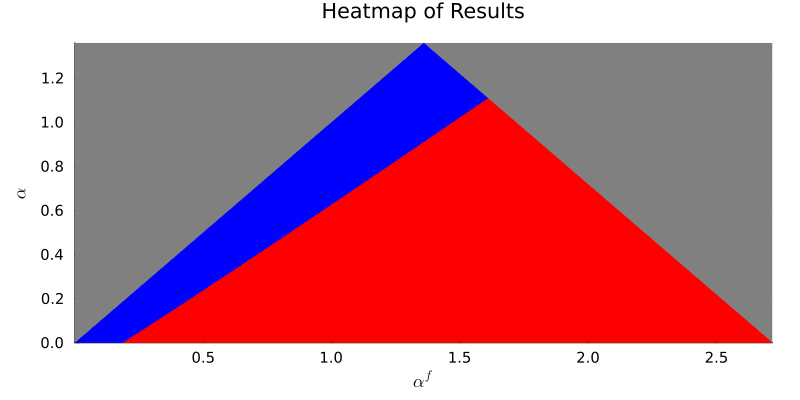

In [6]:
# Specify delta and load results
delta_val = 0.001

loaded_dataframe = CSV.File("compare001.csv", header=false) |> DataFrame
results_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)
plot!(size=(800, 400), margin=5Plots.mm)